In [456]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from plotnine import *

In [457]:
df_draft_raw = pd.read_csv("../data/draft.csv", index_col=0)

In [458]:
df_draft = (df_draft_raw.rename(columns={'Lg': 'league', 'Rd': 'round', 
                                         'Pk': 'pick', 'Tm': 'team', 'Pos': 'position'})
              .assign(Player = lambda x: x.Player.str.split('\\').str.get(0)))
df_draft.columns = df_draft.columns.str.lower()

In [459]:
df_draft.head()

,year,league,round,pick,team,player,age,position,born,college
Rk,,,,,,,,,,
1,2016,NBA,1,1,PHI,Ben Simmons,19.343,G-F,au,Louisiana State University
2,2016,NBA,1,2,LAL,Brandon Ingram,18.299,F,us,Duke University
3,2016,NBA,1,3,BOS,Jaylen Brown,19.247,F-G,us,University of California
4,2016,NBA,1,4,PHO,Dragan Bender,18.223,F,ba,NaN
5,2016,NBA,1,5,MIN,Kris Dunn,22.103,G,us,Providence College


In [460]:
df_nba_raw = pd.read_csv("../data/nbarookiedata.csv", skiprows=1, index_col=0)

In [461]:
df_nba = (df_nba_raw
             .assign(Player = lambda x: x.Player.str.split('\\').str.get(0),
                     Season = lambda x: pd.to_numeric(x.Season.str.split('-').str.get(0)))
             [['Player', 'Tm', 'Season', 'PTS', 'TRB', 'AST', 'STL', 'BLK']]
             .rename(columns={'Player': 'player', 'Tm': 'team', 'Season': 'year', 
                              'PTS': 'point', 'TRB': 'rebound', 'AST': 'assist',
                              'STL': 'steal', 'BLK': 'block'}))

In [462]:
df_nba.head()

,player,team,year,point,rebound,assist,steal,block
Rk,,,,,,,,
1,Alex Abrines,OKC,2016,6.0,1.3,0.6,0.5,0.1
2,Ron Baker,NYK,2016,4.1,1.9,2.1,0.7,0.2
3,Wade Baldwin,MEM,2016,3.2,1.4,1.8,0.5,0.2
4,Malik Beasley,DEN,2016,3.8,0.8,0.5,0.3,0.0
5,DeAndre' Bembry,ATL,2016,2.7,1.6,0.7,0.2,0.1


In [463]:
df_final = pd.merge(df_draft, df_nba, how='left', on=['player', 'team', 'year'])

In [464]:
# There are a lot of players drafted but don't appear in the NBA dataset, why?
df_final.head()

,year,league,round,pick,team,player,age,position,born,college,point,rebound,assist,steal,block
0,2016,NBA,1,1,PHI,Ben Simmons,19.343,G-F,au,Louisiana State University,NaN,NaN,NaN,NaN,NaN
1,2016,NBA,1,2,LAL,Brandon Ingram,18.299,F,us,Duke University,9.4,4.0,2.1,0.6,0.5
2,2016,NBA,1,3,BOS,Jaylen Brown,19.247,F-G,us,University of California,6.6,2.8,0.8,0.4,0.2
3,2016,NBA,1,4,PHO,Dragan Bender,18.223,F,ba,NaN,3.4,2.4,0.5,0.2,0.5
4,2016,NBA,1,5,MIN,Kris Dunn,22.103,G,us,Providence College,3.8,2.1,2.4,1.0,0.5


In [465]:
df_ncaa_raw = pd.read_csv('../data/ncaa2.csv', index_col=0)

In [466]:
df_ncaa_raw.columns

Index(['Name', 'Team', 'GP', 'Min', 'Pts', 'FG', 'FGA', 'FG%', '2Pt', '2PtA',
       '2P%', '3Pt', '3PtA', '3P%', 'FTM', 'FTA', 'FT%', 'Off', 'Def', 'TOT',
       'Asts', 'Stls', 'Blks', 'TOs', 'PFs', 'year', 'PTs/g', 'FGA/g',
       'Pts/Play', 'TS%', 'eFG%', 'FTA/FGA', '3PA/FGA', 'Ast/g', 'Ast/FGA',
       'A/TO', 'PPR', 'BK/g', 'STL/g', 'PF/g'],
      dtype='object')

In [467]:
df_ncaa = (df_ncaa_raw
              [['Name', 'Team', 'year', 'Pts', 'TOT', 'Asts', 'Stls', 'Blks']]
              .rename(columns={'Name': 'player', 'Team': 'college', 'year': 'col_year',
                               'Pts': 'col_point', 'TOT': 'col_rebound', 'Asts': 'col_assist',
                               'Stls': 'col_steal', 'Blks': 'col_block'}))

In [468]:
df_ncaa.head()

,player,college,col_year,col_point,col_rebound,col_assist,col_steal,col_block
0,Luis Rivas,Western Illinois,2002,27.9,10.7,0.0,0.0,0.5
1,Steve Reynolds,Western Michigan,2002,27.8,6.5,2.0,1.2,0.1
2,Michael Watson,UMKC,2002,24.9,3.6,3.2,2.1,0.2
3,Tyrone Hayes,Idaho,2002,34.3,12.3,0.0,2.5,2.5
4,Travis Robinson,Jacksonville,2002,27.4,7.5,1.1,1.9,0.3


In [469]:
df_final = pd.merge(df_final, df_ncaa, how='inner', on=['player'])

In [470]:
df_draft.shape

(1125, 10)

In [471]:
df_final.shape

(1544, 22)

In [472]:
print("Number of unique players: {}".format(len(pd.unique(df_final.player))))

Number of unique players: 613


In [473]:
# Only keep the last year of college performance
df_final = (df_final.groupby('player')
        .apply(lambda df: df.sort_values(by='col_year', ascending=False).iloc[0, :]))

In [474]:
df_final

,year,league,round,pick,team,player,age,position,born,college_x,...,assist,steal,block,college_y,col_year,col_point,col_rebound,col_assist,col_steal,col_block
player,,,,,,,,,,,,,,,,,,,,,
A.J. Hammons,2016,NBA,2,46,DAL,A.J. Hammons,23.306,C,us,Purdue University,...,0.2,0.0,0.6,Purdue,2014,16.6,11.4,0.7,0.6,4.7
A.J. Price,2009,NBA,2,52,IND,A.J. Price,22.267,G,us,University of Connecticut,...,1.9,0.6,0.1,Connecticut,2009,17.8,4.2,5.7,0.8,0.0
Aaron Brooks,2007,NBA,1,26,HOU,Aaron Brooks,22.170,G,us,University of Oregon,...,1.7,0.3,0.1,Oregon,2007,19.2,4.6,4.6,1.5,0.2
Aaron Gordon,2014,NBA,1,4,ORL,Aaron Gordon,18.288,F,us,University of Arizona,...,0.7,0.4,0.5,Arizona,2014,16.3,10.5,2.6,1.2,1.4
Aaron Gray,2007,NBA,2,49,CHI,Aaron Gray,22.208,C,us,University of Pittsburgh,...,0.7,0.3,0.3,Pittsburgh,2007,20.5,14.0,2.5,0.6,2.5
Aaron White,2015,NBA,2,49,WAS,Aaron White,22.293,F,us,University of Iowa,...,NaN,NaN,NaN,Iowa,2014,17.2,9.0,2.4,1.3,0.8
Acie Law,2007,NBA,1,11,ATL,Acie Law,22.159,G,us,Texas A&M University,...,2.0,0.5,0.0,Texas A&M,2007,21.6,4.0,6.0,1.4,0.0
Adam Haluska,2007,NBA,2,43,NOK,Adam Haluska,NaN,NaN,NaN,University of Iowa,...,NaN,NaN,NaN,Iowa,2007,24.2,5.5,3.0,1.6,0.3
Adam Morrison,2006,NBA,1,3,CHA,Adam Morrison,21.349,F,us,Gonzaga University,...,2.1,0.4,0.1,Gonzaga,2006,29.3,5.8,1.8,1.1,0.3


# Model building

In [475]:
df_final = df_final.dropna()
X = df_final[['round', 'pick', 'position',
              'col_point', 'col_rebound', 'col_assist', 'col_steal', 'col_block']]
X = pd.get_dummies(X, columns=['position'])
y = df_final['point']

In [476]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [477]:
rf = RandomForestRegressor(criterion='mse', n_jobs=-1)
rf.get_params()

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
gs = GridSearchCV(estimator=rf, 
                  param_grid=[{'n_estimators': [100, 1000, 10000],
                               'min_samples_leaf': [1, 10, 100]}],
                  cv=10, scoring='neg_mean_squared_error')

In [ ]:
gs.fit(X_train, y_train)

In [ ]:
gs.best_params_

In [ ]:
best_rf = gs.best_estimator_
best_rf.fit(X_train, y_train)

In [ ]:
mean_squared_error(y_train, best_rf.predict(X_train))

In [ ]:
y_pred = best_rf.predict(X_test)

In [ ]:
print("Min / Mean / Max of Point: {} {} {}".format(np.min(df_final.point),
                                                   np.mean(df_final.point),
                                                   np.max(df_final.point)))
print("Train MSE: {.3f}; Test MSE: {.3f}".format(mean_squared_error(y_train, best_rf.predict(X_train),
                                                 mean_squared_error(y_test, best_rf.predict())))

/Users/anh/miniconda3/lib/python3.6/site-packages/plotnine/stats/stat_bin.py:90: UserWarning: 'stat_bin()' using 'bins = 15'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']))


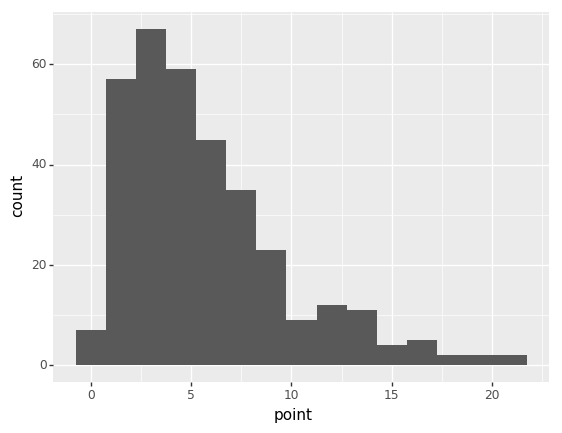

<ggplot: (-9223372036549853745)>

In [455]:
ggplot(data=df_final) + geom_histogram(aes(x='point'))